# Langgraph notebook 2
https://langchain-ai.github.io/langgraph/

Building agents from graphs

From tutorial: https://langchain-ai.github.io/langgraph/tutorials/chatbots/information-gather-prompting/

In [2]:
# The basics

from dotenv import load_dotenv
import os
import json
import re
from openai import OpenAI

load_dotenv()
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

## Gather information

In [5]:
from typing import List, Dict, Any
from langchain_core.messages import SystemMessage
from langchain_core.pydantic_v1 import BaseModel
from langchain_openai import ChatOpenAI

In [20]:
template = """Your job is to gather information from a user about the Opentrons liquid handling task or workflow they want to perform. You should get the following information:

- A detailed description of the workflow, including all steps to be performed. A workflow could also be a single step/operation.
- Information about the deck setup, including:
  - Attached pipettes
  - Labware on the deck
  - Tip racks
  - Any modules (e.g., thermocycler, magnetic module)

For each step in the workflow, gather relevant details such as:
- The specific operation (e.g., transfer, mix, dispense, thermocycler operation)
- Volumes of liquid involved (if applicable)
- Source and destination containers (if applicable)
- Pipette to be used (if applicable - often safe to select a pipe based on the volume)
- Any other relevant parameters for the operation

If any information is missing or unclear, ask the user to clarify. Do not guess or assume any details. Make sure you have a representation of the deck state before calling the relevant tools. Safety and accuracy are paramount in lab operations.

After you have gathered all necessary information, organize it into a list of workflow steps and the deck state, then call the relevant tool."""


def get_messages_info(messages):
    return [SystemMessage(content=template)] + messages

class OpentronsDeckState(BaseModel):
    """Information about the current state of the Opentrons deck."""
    pipettes: Dict[str, str]  # e.g., {"left": "p300_single", "right": "p1000_multi"}
    labware: Dict[str, str]  # e.g., {"1": "opentrons_24_tuberack_eppendorf_1.5ml_safelock_snapcap"}
    tip_racks: Dict[str, str]  # e.g., {"2": "opentrons_96_tiprack_300ul"}
    modules: Dict[str, str]  # e.g., {"7": "thermocycler"}


class OpentronsInstructions(BaseModel):
    """Flexible instructions for Opentrons liquid handling tasks."""
    workflow: List[Dict[str, Any]]  # A list of steps in the workflow
    deck_state: OpentronsDeckState


llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
llm_with_tool = llm.bind_tools([OpentronsInstructions])

chain = get_messages_info | llm_with_tool

## Generate code

In [21]:
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage, SystemMessage

# New system prompt for code generation
code_gen_system = """Based on the following Opentrons workflow and deck state, generate Python code using the Opentrons API:

{instructions}

Ensure the code follows best practices for the Opentrons API, includes proper error handling, and is well-commented for clarity."""

# Function to get the messages for code generation
# Will only get messages AFTER the tool call
def get_code_gen_messages(messages: list):
    tool_call = None
    other_msgs = []
    for m in messages:
        if isinstance(m, AIMessage) and m.tool_calls:
            tool_call = m.tool_calls[0]["args"]
        elif isinstance(m, ToolMessage):
            continue
        elif tool_call is not None:
            other_msgs.append(m)
    return [SystemMessage(content=code_gen_system.format(instructions=tool_call))] + other_msgs

code_gen_chain = get_code_gen_messages | llm

## Define the state logic

In [22]:
from typing import Literal
from langgraph.graph import END

def get_state(messages) -> Literal["add_tool_message", "info", "__end__"]:
    if isinstance(messages[-1], AIMessage) and messages[-1].tool_calls:
        return "add_tool_message"
    elif not isinstance(messages[-1], HumanMessage):
        return END
    return "info"

## Create the graph

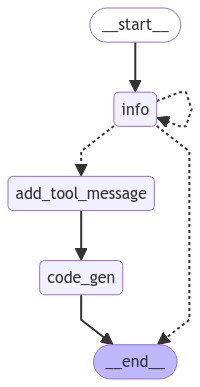

In [23]:
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import START, MessageGraph
from langchain_core.messages import ToolMessage

memory = SqliteSaver.from_conn_string(":memory:")
workflow = MessageGraph()

# Add nodes
workflow.add_node("info", chain)
workflow.add_node("code_gen", code_gen_chain)

@workflow.add_node
def add_tool_message(state: list):
    return ToolMessage(
        content="Opentrons instructions received. Generating code...",
        tool_call_id=state[-1].tool_calls[0]["id"]
    )

# Add edges
workflow.add_conditional_edges("info", get_state)
workflow.add_edge("add_tool_message", "code_gen")
workflow.add_edge("code_gen", END)
workflow.add_edge(START, "info")

# Compile the graph
graph = workflow.compile(checkpointer=memory)

# Visualization (if in a Jupyter environment)
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

## Use the graph

In [25]:
import uuid

config = {"configurable": {"thread_id": str(uuid.uuid4())}}
while True:
    user = input("User (q/Q to quit): ")
    if user in {"q", "Q"}:
        print("AI: Byebye")
        break
    output = None
    for output in graph.stream(
        [HumanMessage(content=user)], config=config, stream_mode="updates"
    ):
        last_message = next(iter(output.values()))
        last_message.pretty_print()

    if output and "code_gen" in output:
        print("Done!")

================================== Ai Message ==================================

To assist you with your liquid handling task, I need some additional information:

1. **Deck Setup:**
   - What type of pipette do you have attached? (e.g., P300, P1000)
   - What type of labware are you using for the 96-well plates? (e.g., standard 96-well plate, deep well plate)
   - Are there any tip racks on the deck? If so, please specify their locations.
   - Are there any modules attached to the deck? (e.g., thermocycler, magnetic module)

2. **Workflow Details:**
   - Are you using the same well positions on both plates? (e.g., transferring from A1 to A1, B1 to B1, etc.)
   - Do you want to mix the wells after dilution? If so, please specify the mixing details (e.g., number of mixes, volume).
   - Is there any specific order in which you want to perform the dilutions?

Once I have this information, I can help you organize the workflow steps and the deck state.
================================== Ai